In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import holidays
from datetime import datetime

from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam



kr_holidays = holidays.US(years=2019)
kr_holidays

{datetime.date(2019, 1, 21): 'Martin Luther King Jr. Day', datetime.date(2019, 2, 18): "Washington's Birthday", datetime.date(2019, 10, 14): 'Columbus Day', datetime.date(2019, 1, 1): "New Year's Day", datetime.date(2019, 5, 27): 'Memorial Day', datetime.date(2019, 7, 4): 'Independence Day', datetime.date(2019, 9, 2): 'Labor Day', datetime.date(2019, 11, 11): 'Veterans Day', datetime.date(2019, 11, 28): 'Thanksgiving', datetime.date(2019, 12, 25): 'Christmas Day'}

In [2]:
def is_weekend(date):
    return date.weekday() >= 5

def get_weekends_and_holidays(date):
    if is_weekend(date):
        return 1
    elif date in kr_holidays:
        return 1
    else:
        return 0

# Data preprocessing

In [3]:
custom_info = pd.read_csv('./Customer_info.csv')
discount_info = pd.read_csv('./Discount_info.csv')
marketing_info = pd.read_csv('./Marketing_info.csv')
online_info = pd.read_csv('./Onlinesales_info.csv')
tax_info = pd.read_csv('./Tax_info.csv') # Goods and Services Tax(%)

marketing_info.columns = ['거래날짜','오프라인비용','온라인비용']
tp = {j:i+1 for i,j in zip(range(12),discount_info['월'].unique())}
discount_info['월'] = [tp[i] for i in discount_info['월']]

data = pd.merge(online_info,tax_info,on='제품카테고리')
data['월'] = data['거래날짜'].apply(lambda x:int(x.split('-')[1]))
data = pd.merge(data,custom_info,on='고객ID')
data = pd.merge(data,marketing_info,on='거래날짜')
data['거래날짜'] = pd.to_datetime(data['거래날짜'])
data['휴일'] = data['거래날짜'].apply(lambda x:get_weekends_and_holidays(x))
data = pd.merge(data,discount_info,on=['월','제품카테고리'])
data['제품ID'] = data['제품ID'].apply(lambda x:x.split('_')[1]).astype('int32')

for tar in ['수량','평균금액','배송료']:
    data[tar] = data[tar].astype('float32')
    
data = data.drop('쿠폰코드',axis=1)
for i in tqdm(range(len(data))):
    tp = data.loc[i,:]
    if tp ['쿠폰상태'] != 'Clicked':
        data.loc[i,'할인율'] = 0
        
data['지불금액'] = (data['수량']*data['평균금액'])*((100-data['할인율'])/100)+data['배송료']
data['총마케팅비용'] = data['오프라인비용'] + data['온라인비용']

data['제품카테고리'] = data['제품카테고리'].apply(lambda x:x.split('-')[0])
data['제품카테고리'] = data['제품카테고리'].replace('Bottles','Drinkware')
data['제품카테고리'] = data['제품카테고리'].replace('Housewares','Lifestyle')

100%|██████████████████████████████████████████████████████████████████████████| 52524/52524 [00:07<00:00, 6885.46it/s]


In [4]:
data['제품카테고리'].value_counts()

Apparel                 18126
Nest                    16528
Office                   6513
Drinkware                3751
Lifestyle                3214
Bags                     1882
Headgear                  771
Notebooks & Journals      749
Waze                      554
Accessories               234
Gift Cards                159
Android                    43
Name: 제품카테고리, dtype: int64

# 마케팅 비용에 따른 효과분석

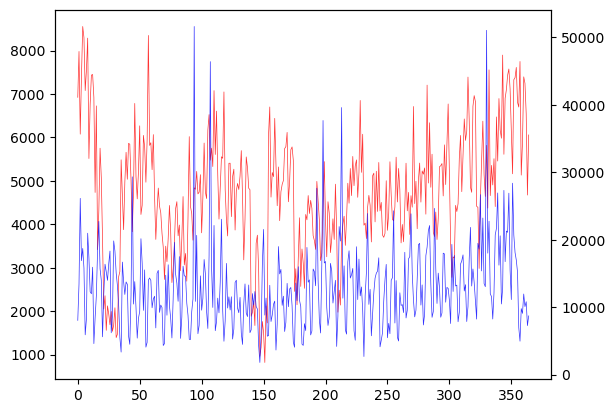

In [73]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(data[['거래날짜','총마케팅비용']].groupby('거래날짜').mean().values, color='red', alpha=0.8, lw=0.5)
ax2.plot(data[['거래날짜','지불금액']].groupby('거래날짜').sum().values, color='blue', alpha=0.8, lw=0.5)

Text(0.5, 1.0, 'marketing efficiency')

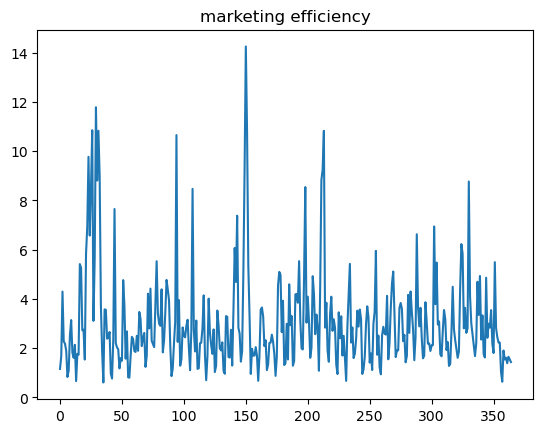

In [74]:
target = data[['거래날짜','총마케팅비용']].groupby('거래날짜').mean().values/data[['거래날짜','지불금액']].groupby('거래날짜').sum().values
target = 1/target
plt.plot(target)
plt.title("marketing efficiency")

# 매출액 추세 및 예측 RNN, ARIMA

Epoch 1/20
10/10 [==============================] - 1s 3ms/step - loss: 0.0446
Epoch 2/20
10/10 [==============================] - 0s 2ms/step - loss: 0.0219
Epoch 3/20
10/10 [==============================] - 0s 2ms/step - loss: 0.0185
Epoch 4/20
10/10 [==============================] - 0s 2ms/step - loss: 0.0183
Epoch 5/20
10/10 [==============================] - 0s 2ms/step - loss: 0.0166
Epoch 6/20
10/10 [==============================] - 0s 2ms/step - loss: 0.0159
Epoch 7/20
10/10 [==============================] - 0s 2ms/step - loss: 0.0152
Epoch 8/20
10/10 [==============================] - 0s 2ms/step - loss: 0.0147
Epoch 9/20
10/10 [==============================] - 0s 2ms/step - loss: 0.0140
Epoch 10/20
10/10 [==============================] - 0s 2ms/step - loss: 0.0135
Epoch 11/20
10/10 [==============================] - 0s 2ms/step - loss: 0.0131
Epoch 12/20
10/10 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 13/20
10/10 [==============================

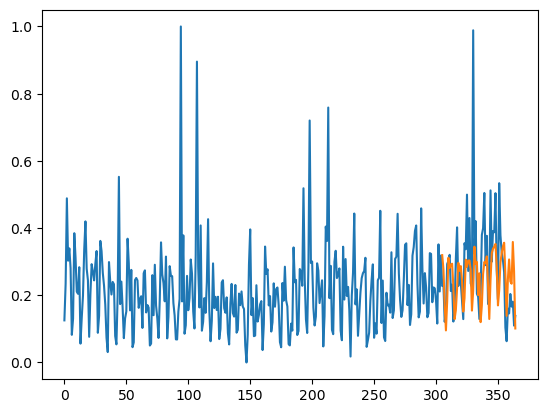

In [6]:
marketing_info = pd.read_csv('./Marketing_info.csv')
marketing_info['날짜'] = pd.to_datetime(marketing_info['날짜'])
marketing_info['Month'] = pd.to_datetime(marketing_info['날짜']).dt.month
marketing_info['Day'] = pd.to_datetime(marketing_info['날짜']).dt.day
marketing_info['휴일'] = marketing_info['날짜'].apply(lambda x:get_weekends_and_holidays(x))
marketing_info['매출액'] = data[['거래날짜','지불금액']].groupby('거래날짜').sum()['지불금액'].values
marketing_info = marketing_info.drop('날짜',axis=1)



def normalize_data(X):
    scaler = MinMaxScaler()
    X_normalized = scaler.fit_transform(X)
    return X_normalized

for col in marketing_info.columns:
    marketing_info[[col]] = normalize_data(marketing_info[[col]])

def create_sequences(data, labels, seq_length, pre_cut_idx):
    sequences = []
    labels_seq = []
    label = data[labels]
    data = data.drop(labels,axis=1)
    for i in range(len(data) - seq_length):
        sequence = data[i:i + seq_length]
        sequences.append(sequence)
        labels_seq.append(label[i + seq_length - 1])
    return np.array(sequences)[:-pre_cut_idx], np.array(labels_seq)[:-pre_cut_idx],np.array(sequences)[-pre_cut_idx:], np.array(labels_seq)[-pre_cut_idx:], 
            

seq_length = 3
pre_cut_length = 60
X,y,X_test,y_test = create_sequences(marketing_info,'매출액', seq_length, pre_cut_length)

# LSTM 모델 생성
model = Sequential()
model.add(LSTM(16))
model.add(Dense(1))
optimizer = Adam(lr=0.001)
model.compile(optimizer='adam', loss='mse')

# 모델 훈련
model.fit(X, y, epochs=20, verbose=1)
print('Fin.')

plt.plot(marketing_info['매출액'])
plt.plot([i for i in range(len(X)+seq_length,len(marketing_info))],model.predict(X_test))

C:\Users\User\anaconda3\envs\git_repo\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\User\anaconda3\envs\git_repo\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\User\anaconda3\envs\git_repo\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


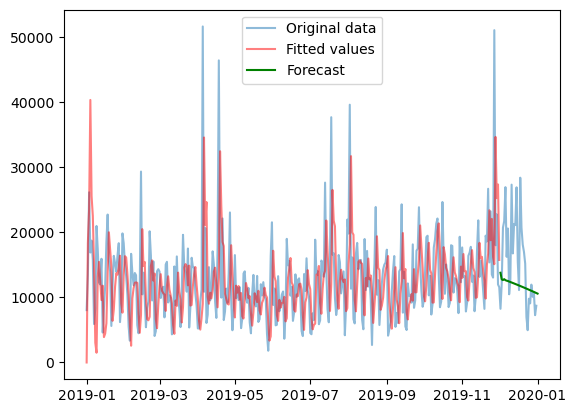

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

marketing_info = pd.read_csv('./Marketing_info.csv')
marketing_info['날짜'] = pd.to_datetime(marketing_info['날짜'])
# marketing_info['Month'] = pd.to_datetime(marketing_info['날짜']).dt.month
# marketing_info['Day'] = pd.to_datetime(marketing_info['날짜']).dt.day
marketing_info['휴일'] = marketing_info['날짜'].apply(lambda x:get_weekends_and_holidays(x))
marketing_info['매출액'] = data[['거래날짜','지불금액']].groupby('거래날짜').sum()['지불금액'].values

pred_nums = 31
ts = pd.Series(marketing_info.loc[:len(marketing_info)-pred_nums,'매출액'])
ts.index = marketing_info.loc[:len(marketing_info)-pred_nums,'날짜']

model = ARIMA(ts, order=(3, 3, 3))
results = model.fit()
forecast = results.forecast(steps=pred_nums)


marketing_info = marketing_info.set_index('날짜')
plt.plot(marketing_info['매출액'], label='Original data',alpha=0.5)
plt.plot(results.fittedvalues, color='red', label='Fitted values', alpha=0.5)
plt.plot(forecast, color='green', label='Forecast')
plt.legend()
plt.show()


# 구매성향 정의, 분류, 그룹수와 특징

In [102]:
data

,고객ID,거래ID,거래날짜,제품ID,제품카테고리,수량,평균금액,배송료,쿠폰상태,GST,월,성별,고객지역,가입기간,오프라인비용,온라인비용,휴일,할인율,지불금액,총마케팅비용
0,USER_1358,Transaction_0000,2019-01-01,981,Nest,1.0,153.710007,6.5,Used,0.10,1,남,Chicago,12,4500,2424.50,1,0,160.210007,6924.50
1,USER_1358,Transaction_0001,2019-01-01,981,Nest,1.0,153.710007,6.5,Used,0.10,1,남,Chicago,12,4500,2424.50,1,0,160.210007,6924.50
2,USER_1358,Transaction_0013,2019-01-01,983,Nest,2.0,122.769997,6.5,Not Used,0.10,1,남,Chicago,12,4500,2424.50,1,0,252.039993,6924.50
3,USER_1358,Transaction_0015,2019-01-01,984,Nest,1.0,81.500000,6.5,Clicked,0.10,1,남,Chicago,12,4500,2424.50,1,10,79.850000,6924.50
4,USER_1358,Transaction_0016,2019-01-01,981,Nest,1.0,153.710007,6.5,Clicked,0.10,1,남,Chicago,12,4500,2424.50,1,10,144.839006,6924.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52519,USER_0227,Transaction_4392,2019-03-10,911,Gift Cards,1.0,250.000000,0.0,Clicked,0.05,3,여,California,8,2500,1294.22,1,30,175.000000,3794.22
52520,USER_1423,Transaction_5483,2019-03-28,910,Gift Cards,1.0,25.000000,0.0,Used,0.05,3,남,Chicago,34,2000,1066.12,0,0,25.000000,3066.12
52521,USER_0919,Transaction_18394,2019-10-06,959,Notebooks & Journals,1.0,10.800000,6.0,Clicked,0.05,10,남,California,15,3000,2230.76,1,10,15.720000,5230.76
52522,USER_0919,Transaction_18394,2019-10-06,964,Notebooks & Journals,1.0,9.600000,6.0,Used,0.05,10,남,California,15,3000,2230.76,1,0,15.600000,5230.76


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.64it/s]


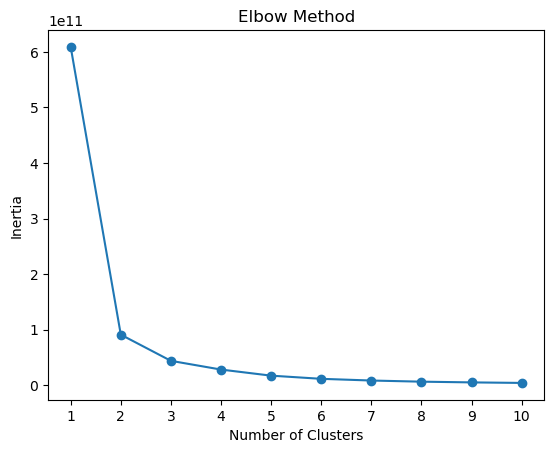

In [6]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


target = ['제품카테고리','수량','평균금액','가입기간','배송료','쿠폰상태','GST','성별','고객지역','휴일','할인율','지불금액']
tp = data[target]
encoder = LabelEncoder()
for i in ['제품카테고리','쿠폰상태','성별','고객지역','GST','성별','할인율','지불금액']:
    tp[i] = encoder.fit_transform(tp[i])

scaler = StandardScaler()
for i in ['수량','평균금액','배송료']:
    tp[i] = scaler.fit_transform(tp[[i]])
    
clusters_range = range(1, 11)
inertia = []

# 각 클러스터 개수에 대해 k-means 수행
for k in tqdm(clusters_range):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(tp)
    inertia.append(kmeans.inertia_)

# 엘보우 그래프 시각화
plt.plot(clusters_range, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.xticks(clusters_range)
plt.show()

  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

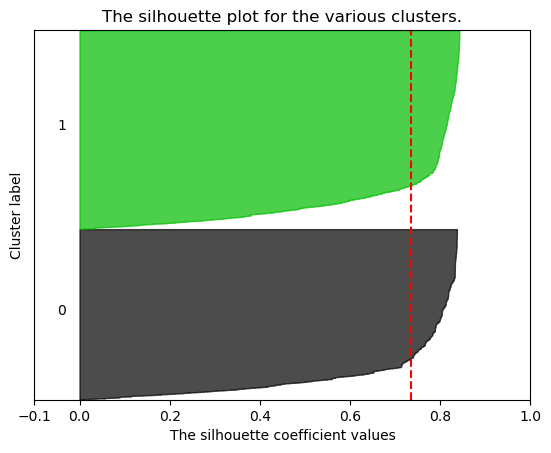

 12%|██████████▌                                                                         | 1/8 [01:03<07:26, 63.78s/it]

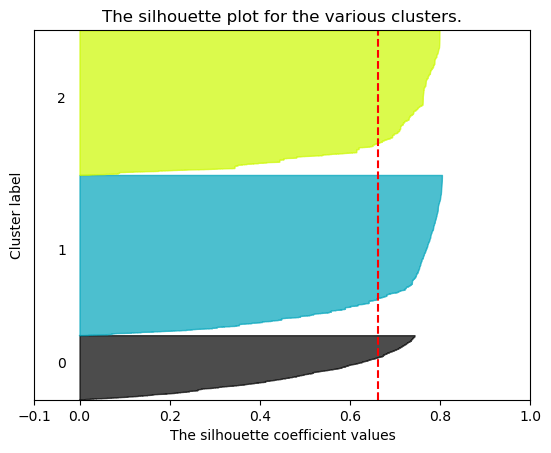

 25%|█████████████████████                                                               | 2/8 [02:04<06:13, 62.17s/it]

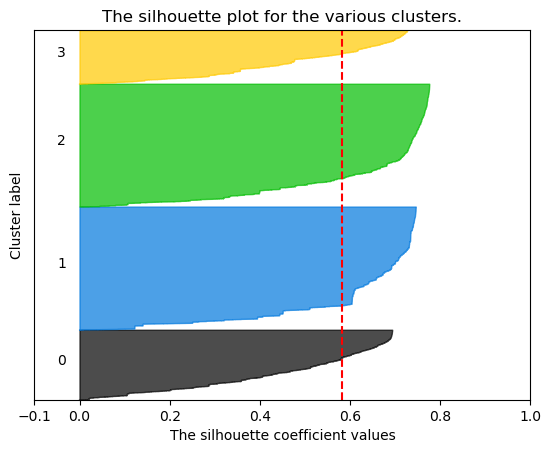

 38%|███████████████████████████████▌                                                    | 3/8 [03:03<05:03, 60.71s/it]

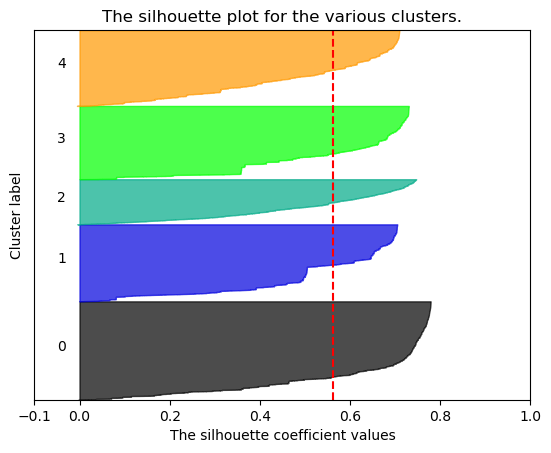

 50%|██████████████████████████████████████████                                          | 4/8 [04:01<03:57, 59.47s/it]

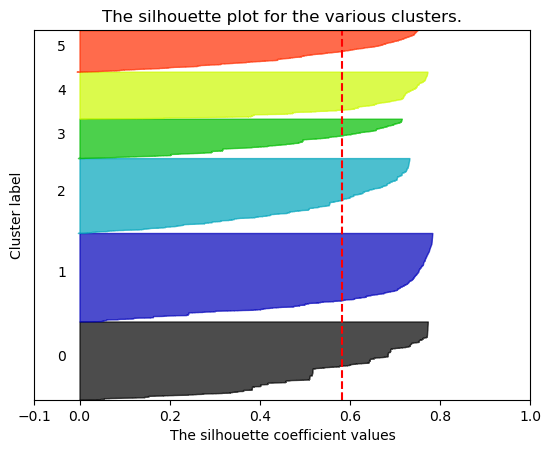

 62%|████████████████████████████████████████████████████▌                               | 5/8 [04:57<02:55, 58.42s/it]

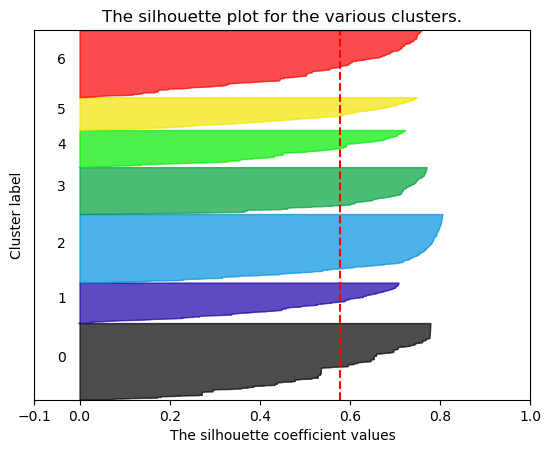

 75%|███████████████████████████████████████████████████████████████                     | 6/8 [05:52<01:54, 57.25s/it]

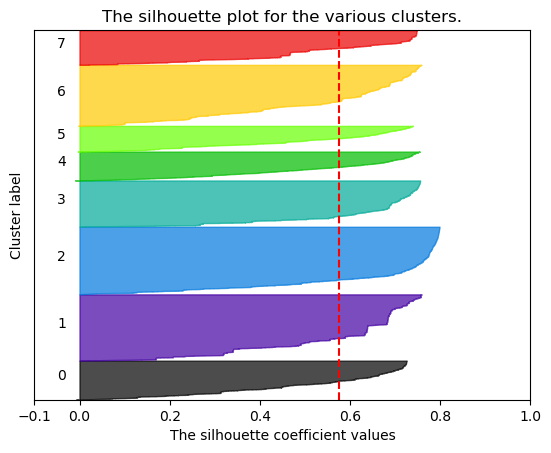

 88%|█████████████████████████████████████████████████████████████████████████▌          | 7/8 [06:49<00:57, 57.04s/it]

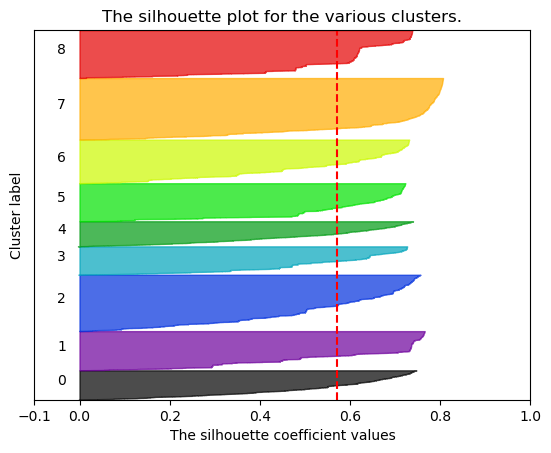

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [07:44<00:00, 58.07s/it]


In [156]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

# 가상의 데이터 생성

# 클러스터 개수 범위 지정
clusters_range = range(2, 10)
silhouette_avg_list = []

for n_clusters in tqdm(clusters_range):
    # KMeans 모델 생성
    kmeans = KMeans(n_clusters=n_clusters)
    cluster_labels = kmeans.fit_predict(tp)
    
    # 모든 데이터 포인트의 실루엣 스코어 계산
    silhouette_avg = silhouette_score(tp, cluster_labels)
    silhouette_avg_list.append(silhouette_avg)
    
    # 각 데이터 포인트의 실루엣 스코어 계산
    sample_silhouette_values = silhouette_samples(tp, cluster_labels)

    # 실루엣 스코어 시각화
    fig, ax = plt.subplots(1, 1)
    ax.set_xlim([-0.1, 1])
    ax.set_ylim([0, len(tp) + (n_clusters + 1) * 10])
    y_lower = 10

    for i in range(n_clusters):
        # 클러스터 i에 속하는 데이터의 실루엣 스코어를 정렬
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # 다음 클러스터를 그리기 위한 공백

    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # y축 라벨은 제거
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.show()


In [7]:
import seaborn as sns
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)
tp = tsne.fit_transform(tp)
tp = pd.DataFrame(tp,columns=['x','y'])
# kmeans = KMeans(n_clusters=6,init='k-means++')
# labels = kmeans.fit_predict(tp)
# tp['label'] = labels
# data['label'] = labels
tp


,x,y
0,44.020523,-32.427586
1,44.020557,-32.427479
2,94.890640,87.818329
3,30.235800,-0.904056
4,69.016289,20.969778
...,...,...
52519,72.137947,-15.261340
52520,-15.221549,117.528305
52521,-67.041122,33.234108
52522,-73.063271,41.355644


<AxesSubplot: xlabel='x', ylabel='y'>

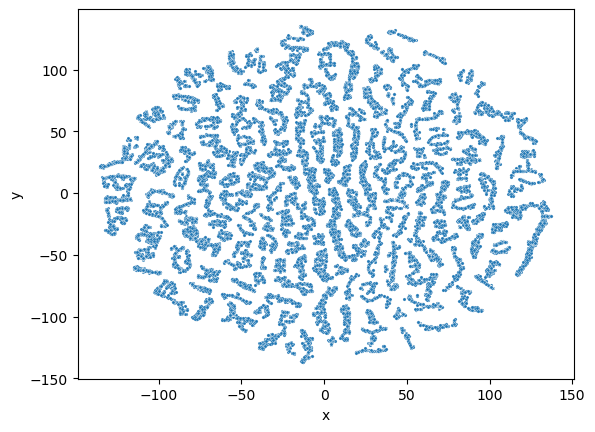

In [9]:
sns.scatterplot(data=tp,x='x',y='y',s=5)

4


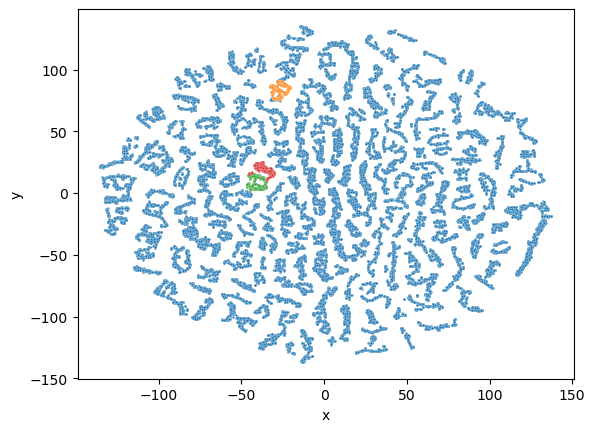

In [15]:
dbscan = DBSCAN(eps=7, min_samples=300, metric='euclidean')
prediction = dbscan.fit_predict(tp)
print(len(set(dbscan.labels_)))

tp['label'] = prediction

for i in range(-1,len(set(dbscan.labels_))):
    sns.scatterplot(data=tp[tp['label']==i],x='x',y='y',s=3)

In [45]:
tp['label'].value_counts()

-1     24509
 6      3037
 0      1354
 26      992
 5       904
 1       830
 3       797
 8       771
 11      737
 2       728
 44      686
 16      684
 18      638
 9       600
 21      591
 30      578
 15      573
 10      561
 28      536
 13      521
 39      519
 14      510
 4       462
 31      458
 27      439
 41      437
 32      432
 7       428
 22      401
 12      399
 19      389
 25      370
 43      369
 33      368
 20      365
 47      364
 36      355
 45      348
 17      345
 23      337
 42      336
 40      336
 35      319
 48      317
 29      314
 49      312
 38      303
 34      302
 51      301
 50      262
 46      255
 37      233
 24      212
Name: label, dtype: int64

In [196]:
# from sklearn.cluster import DBSCAN

# target = ['제품카테고리','수량','평균금액','가입기간','배송료','쿠폰상태','GST','성별','고객지역','휴일','할인율','지불금액']
# tp = data[target]
# encoder = LabelEncoder()
# for i in ['제품카테고리','쿠폰상태','성별','고객지역','GST','성별','할인율','지불금액']:
#     tp[i] = encoder.fit_transform(tp[i])

# scaler = StandardScaler()
# for i in ['수량','평균금액','배송료','가입기간','지불금액']:
#     tp[i] = scaler.fit_transform(tp[[i]])
    
# dbscan = DBSCAN(eps=2, min_samples=30, metric='euclidean')
# prediction = dbscan.fit_predict(tp)

In [197]:
pd.DataFrame(prediction).value_counts()

 0    26573
 1    23222
 2     1089
-1      843
 3      540
 4      227
 5       30
dtype: int64

# 협업필터링

In [47]:
co_data = data[['고객ID','제품ID']]
user_item_matrix = co_data.groupby(['고객ID','제품ID']).size().unstack(fill_value=0)
user_item_matrix[user_item_matrix > 1] = 1
user_similarity = cosine_similarity(user_item_matrix)
user_predicted_scores = user_similarity.dot(user_item_matrix) / np.array([np.abs(user_similarity).sum(axis=1)]).T

In [87]:
recommendations = []
for idx, user in enumerate(user_item_matrix.index):
    applied = set(user_item_matrix.loc[user][user_item_matrix.loc[user] == 1].index)
    sorted_indices = user_predicted_scores[idx].argsort()[::-1]
    recommended = [i for i in user_item_matrix.columns[sorted_indices] if job not in applied][:5]
    
    for i in recommended:
        recommendations.append([user, i])

In [100]:
recommedation_data = pd.DataFrame(recommendations,columns=['user','item'])
recommedation_data = pd.DataFrame(recommedation_data.groupby('user'))
recommedation_data.set_index(recommedation_data[0].apply(lambda x:int(x.split('_')[1])),inplace=True)

user_idx = 0
recommedation_data.iloc[user_idx,:][1]

,user,item
0,USER_0000,946
1,USER_0000,976
2,USER_0000,981
3,USER_0000,983
4,USER_0000,984
